# STR Selection Simulation

## Key parameters:
* mu: per-generation mutation rate
* beta: length constraint
* p: step size parameter (geometric distribution)
* S: selection coefficient. Most fit allele has relative fitness 1. Next most has 1-s, next most has 1-2s, etc.
* num_alleles: Size of transition matrix to build. Centered at "0" (most optimal allele in the center)
* L: length-dependent mutation rate where muprime=mu+L(al), where mu is mean mutation rate (for allele 0)

In [1]:
# STR Selection Simulation without avoiding 0's in the various matrices (mutation, covariance, genotype fitness)

########## Function definitions and imports ##########

%pylab inline
import numpy as np
from scipy.stats import geom
import copy

# Geometric step size prob
def GetStepSizeProb(a1, a2, beta, p):
    step_size = (a2-a1)
    if abs(step_size)>10: return 0 # TODO limit? (There is a zero percent chance that a STR will expand/contract more than a certain step size)
    up_prob = max([0,0.5*(1-beta*p*a1)])
    down_prob = 1-up_prob
    if step_size>0: dir_prob = up_prob
    else: dir_prob = down_prob
    step_prob = geom.pmf(abs(step_size), p)
    return dir_prob*step_prob

### Main function to build transition matrix ###
def GetTransitionMatrix(num_alleles, mu, beta, p, L=0):
    # Initialize matrix (optimal=0)
    transition_matrix = np.zeros((num_alleles, num_alleles))

    # Fill in probability to transition from a1 to a2
    for i in range(num_alleles):
        for j in range(num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            mu_prime = mu+L*a1 # Length-dependent mutation rate. TODO should we do a sigmoid curve like Payseur?
            if mu_prime < 0: mu_prime = 0
            if mu_prime > 1: mu_prime = 1
            if a1==a2: transition_matrix[i,j] = 1-mu_prime
            else:
                prob = GetStepSizeProb(a1, a2, beta, p)
                transition_matrix[i,j] = mu_prime*prob
        
    # Rescale each row to sum to 1 (which should hopefully be mostly true anyway)
    for i in range(num_alleles):
        rowsum = np.sum(transition_matrix[i,:])
        transition_matrix[i,:] = transition_matrix[i,:]/rowsum

    return transition_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
########## More function definitions ##########
### Build covariance matrix ###
# TODO minor point, don't need to take in num_alleles, since it is just len(allele_freqs)
# Similar comment for other functions below
def GetCovarianceMatrix(num_alleles, allele_freqs):
    # Initialize matrix 
    covariance_matrix = np.zeros((num_alleles, num_alleles))
    
    # Fill in diagonal elements C[i,i] = p[i](1-p[i])/2 (division by 2 not included here)
    for i in range (0, num_alleles):
        covariance_matrix[i,i] = allele_freqs[i]*(1-allele_freqs[i])
        
    # Fill in off-diagonal elements C[i,j] = -p[i]p[j]/2 (divison by 2 not included here)
    for i in range(0, num_alleles):
        for j in range(0, num_alleles):
            if i != j:
                covariance_matrix[i,j] = -1*allele_freqs[i]*allele_freqs[j]
                
    return covariance_matrix

### Build fitness matrix (fitness of each genotype) ###
# TODO minor point, conflict between NUM_ALLELES and num_alleles
def GetFitnessMatrix(num_alleles, S, is_w_additive):
    fitness_matrix = np.zeros((NUM_ALLELES, NUM_ALLELES))
    for i in range (0, num_alleles):
        for j in range (0, num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            
            # TODO: maybe the max should be applied at the genotype level rather than allele level?
            # Get fitness of each allele, w cannot be less than 0
            w_a1 = max(0, 1-abs(a1)*S) #np.exp(-1*abs(a1)*S) Chance allele won't die, higher w = higher fitness
            w_a2 = max(0, 1-abs(a2)*S) #np.exp(-1*abs(a2)*S) Chance allele won't die, higher w = higher fitness
            
            if is_w_additive == True:
                fitness_matrix[i,j] = w_a1/2 + w_a2/2
                
            if is_w_additive == False:
                fitness_matrix[i,j] = w_a1*w_a2
                
    return fitness_matrix

### Build marginal fitness vector ###
# Marginal fitness of allele i = sum(p[j]w[i,j]) for all alleles j
def GetMarginalFitnessVector(num_alleles, allele_freq, fitness_matrix):
    marginal_fitness_vector = np.zeros(num_alleles)
    for i in range (0, num_alleles):
        for j in range (0, num_alleles):
            marginal_fitness_vector[i] = marginal_fitness_vector[i] + allele_freq[j]*fitness_matrix[i,j]
        
    return marginal_fitness_vector

### Build gradient vector of partial derivatives of mean fitness with respect to each p[i] ###
# Partial derivative with respect with p[i] is equal to twice the marginal fitness of allele a[i]
def GetGradient(num_alleles, marginal_fitness_vector):
    gradient = np.zeros(num_alleles)
    for i in range(0, num_alleles):
        partial_derivative = 2*marginal_fitness_vector[i]
        gradient[i] = partial_derivative
    
    return gradient

### Get mean fitness ###
# Sum of genotypic fitnesses weighted by corresponding genotype frequency
def GetMeanFitness(num_alleles, allele_freq, fitness_matrix):
    mean_fitness = 0
    for i in range(0, num_alleles):
        for j in range(0, num_alleles):
            mean_fitness = mean_fitness + allele_freq[i]*allele_freq[j]*fitness_matrix[i,j]
            
    return mean_fitness

### Get L Norm of 2 allele_freqs vectors ###
# TODO I think it is "L1" norm btw (as opposed to other norms like "L2")
# L Norm is the sum of the abs value of differences of allele frequencies for each allele
def GetLNorm(num_alleles, allele_freqs_prev, allele_freqs):
    l_norm = 0
    for i in range(0, num_alleles):
        l_norm = l_norm + abs(allele_freqs_prev[i] - allele_freqs[i])
        
    return l_norm

Starting allele frequencies
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0.0, 6.242683073235523e-15, 4.545323589440311e-12, 4.5464096452626416e-11, 4.5464096452626426e-10, 4.546409645262644e-09, 4.546409645262645e-08, 4.5464096452626454e-07, 4.5464096452626475e-06, 4.546409645262648e-05, 0.00045464096452626487, 0.006365339357149223, 0.9862590080321987, 0.006365339357149224, 0.0004546409645262649, 4.546409645262648e-05, 4.5464096452626475e-06, 4.5464096452626454e-07, 4.546409645262644e-08, 4.546409645262643e-09, 4.5464096452626426e-10, 4.546409645262641e-11, 4.545323589440311e-12, 6.242683073235523e-15, 0.0]
[0.0, 2.4984951923101857e-14, 4.690404807696989e-12, 4.692578156254684e-11, 4.69270298510084e-10, 4.69270298510084e-09, 4.692702985100842e-08, 4.6927029851008424e-07, 4.692702985100844e-06, 4.692702985100845e-05, 0.00046927029851008464, 0.011972565004338897, 0.9769886122077077, 0.0082222406394313, 0.0022402519052907017, 4.9426921298126334e-05, 4.942

[1.4816807473619738e-14, 3.0220281884683044e-13, 6.944567790421854e-12, 6.983944186847566e-11, 6.984383771778517e-10, 6.984397706278924e-09, 6.984397706278926e-08, 6.984397706278928e-07, 6.984397706278929e-06, 0.0009093783799887982, 0.004145687362020397, 0.0504096151137141, 0.863627571428199, 0.07220602795156283, 0.006915015553726258, 0.001768956273490503, 8.988746763848577e-06, 8.988746763848574e-07, 8.98874676384857e-08, 8.98874676384857e-09, 8.988739796598364e-10, 8.988488605209247e-11, 8.96169077986397e-12, 5.039151177910422e-13, 2.775783509346018e-14]
[9.376339557549447e-15, 2.4461070225313644e-13, 6.37197661863839e-12, 6.412435037250163e-11, 6.412874502208557e-10, 6.412874502208559e-09, 6.41287450220856e-08, 6.41287450220856e-07, 6.412874502208564e-06, 6.412874502208564e-05, 0.005031860364777715, 0.04945898998327457, 0.8643658620002556, 0.07408182285774612, 0.006905869778467431, 7.590676980878302e-05, 7.590676980878302e-06, 7.5906769808783e-07, 7.590676980878298e-08, 7.5906769808

[1.1270093705450238e-14, 3.5196055612176097e-13, 7.302849246289628e-12, 7.344473864949276e-11, 7.345039819654921e-10, 7.345039819654923e-09, 7.345039819654924e-08, 7.345039819654926e-07, 7.345039819654928e-06, 7.34503981965493e-05, 0.006011847860561115, 0.07596880319515643, 0.8331555356674658, 0.07598747970044267, 0.008706851403229323, 7.908355853358896e-05, 7.908355853358893e-06, 7.90835585335889e-07, 7.90835585335889e-08, 7.908355853358888e-09, 7.908355853358886e-10, 7.90797855022179e-11, 7.86635393156214e-12, 4.083110246490122e-13, 1.690514055817536e-14]
[9.390456674482445e-15, 2.733230651158416e-13, 6.552219272483886e-12, 6.597123484020436e-11, 6.598066612495135e-10, 6.598066612495136e-09, 6.598066612495138e-08, 6.598066612495139e-07, 6.598066612495141e-06, 6.598066612495142e-05, 0.005056990069257173, 0.057967601853357045, 0.8409512528847123, 0.08173165288227299, 0.014116426436537896, 9.248762125149256e-05, 9.248762125149255e-06, 9.24876212514925e-07, 9.248762125149249e-08, 9.24876

[1.873990779209491e-15, 1.6633739765950333e-13, 5.608887478473528e-12, 5.6525945754438843e-11, 5.652657313396059e-10, 5.6526573133960595e-09, 5.6526573133960616e-08, 5.652657313396063e-07, 5.652657313396064e-06, 5.652657313396065e-05, 0.001442782283169444, 0.048476992434525114, 0.8687080753367185, 0.07969060932048701, 0.0015446116455390868, 6.670950937092493e-05, 6.670950937092492e-06, 6.670950937092491e-07, 6.670950937092488e-08, 6.670950937092487e-09, 6.670950937092484e-10, 6.670888199140311e-11, 6.645210279670226e-12, 2.6996967777917305e-13, 1.873990779209491e-15]
[1.8744160583960317e-15, 1.7580072992718276e-13, 5.6818722627793936e-12, 5.726682868618856e-11, 5.726745620808638e-10, 5.72674562080864e-09, 5.7267456208086414e-08, 5.726745620808642e-07, 5.726745620808643e-06, 5.726745620808645e-05, 0.0014503902555123994, 0.05130713032888342, 0.8639728884753165, 0.08158219800774583, 0.0015491577533227174, 6.714420598911823e-05, 6.714420598911822e-06, 6.714420598911818e-07, 6.7144205989118

ValueError: pvals < 0, pvals > 1 or pvals contains NaNs

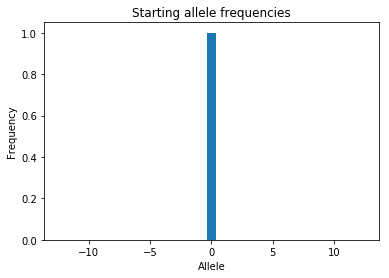

In [18]:
# Visualize an example
NUM_ALLELES = 25

# N_e is effective diploid population size
N_e = 500
THRESHOLD = 1/(2*N_e)

PARAM_beta = 0.3
PARAM_mu = 10e-3
PARAM_p = 0.9
PARAM_S = 0.1
PARAM_L = 0
PARAM_t = 300000 # Maximum number of iterations of while loop (prevent from running forever)

PARAM_is_w_additive = True # Whether the fitness matrix of genotypes is additive or multiplicative

# Set the starting vector of allele frequencies to be equal for all alleles
allele_freqs = np.zeros(NUM_ALLELES)
allele_freqs[int(NUM_ALLELES/2)] = 1.0

#for i in range(NUM_ALLELES):
#    allele_freqs[i] = 1/NUM_ALLELES
    
'''
# Another way to set starting vector of allele frequencies
allele_freqs[int(NUM_ALLELES/2)] = 0.98
allele_freqs[int(NUM_ALLELES/2)+1] = 0.01
allele_freqs[int(NUM_ALLELES/2)-1] = 0.01  
'''

# Visualize starting allele frequencies
fig = plt.figure()
ax = fig.add_subplot(111)
print("Starting allele frequencies")
print(allele_freqs)
ax.bar(list(range(-1*int(NUM_ALLELES/2), int(NUM_ALLELES/2)+1)), allele_freqs)
ax.set_title("Starting allele frequencies")
ax.set_xlabel("Allele")
ax.set_ylabel("Frequency");  
    
# Get transition matrix (constant)
transition_matrix = GetTransitionMatrix(NUM_ALLELES, PARAM_mu, PARAM_beta, PARAM_p, PARAM_L)

# Transpose transition matrix
transition_matrix_transpose = transition_matrix.transpose()
 
# Calculate fitness matrix for each allele pair (genotype)
fitness_matrix = GetFitnessMatrix(NUM_ALLELES, PARAM_S, PARAM_is_w_additive)

# Calculate marginal fitness w*(a[i]) for each allele
marginal_fitness_vector = GetMarginalFitnessVector(NUM_ALLELES, allele_freqs, fitness_matrix)

# Calculate gradient vector of partial derivatives of mean fitness
gradient = GetGradient(NUM_ALLELES, marginal_fitness_vector)
  
# Calculate mean fitness
mean_fitness = GetMeanFitness(NUM_ALLELES, allele_freqs, fitness_matrix)
    
# Calculate covariance matrix
covariance_matrix = GetCovarianceMatrix(NUM_ALLELES, allele_freqs)
    
# Save previous allele_freqs
allele_freqs_prev = copy.deepcopy(allele_freqs)

# Calculate new allele_freqs
# Applying selection
selection_vector = np.matmul(covariance_matrix, gradient)
    
for i in range(NUM_ALLELES):
    selection_vector[i] = selection_vector[i]/(2*mean_fitness)

allele_freqs = allele_freqs + selection_vector
   
# Applying mutation
allele_freqs = np.matmul(transition_matrix_transpose, allele_freqs)

# TODO: Also, probably only need to include all this code once in the while loop
# TODO: some numpy array operations will make things easier. like selection_vector/2*mean_fitness rather than a for loop
# Use multinomial sampling
allele_freqs = np.random.multinomial(2*N_e, allele_freqs)

# Rescale allele_freqs to sum to 1
rowsum = np.sum(allele_freqs)
   
new_allele_freqs = np.zeros(NUM_ALLELES)

for i in range(NUM_ALLELES):
    newVal = allele_freqs[i]/rowsum
    new_allele_freqs[i] = newVal

allele_freqs = new_allele_freqs
   
l_norm = GetLNorm(NUM_ALLELES, allele_freqs_prev, allele_freqs)

t = 0 # Number of iterations of while loop

while l_norm > THRESHOLD and t < PARAM_t:
    # Calculate fitness matrix for each allele pair (genotype)
    fitness_matrix = GetFitnessMatrix(NUM_ALLELES, PARAM_S, PARAM_is_w_additive)

    # Calculate marginal fitness w*(a[i]) for each allele
    marginal_fitness_vector = GetMarginalFitnessVector(NUM_ALLELES, allele_freqs, fitness_matrix)

    # Calculate gradient vector of partial derivatives of mean fitness
    gradient = GetGradient(NUM_ALLELES, marginal_fitness_vector)

    # Calculate mean fitness
    mean_fitness = GetMeanFitness(NUM_ALLELES, allele_freqs, fitness_matrix)

    # Calculate covariance matrix
    covariance_matrix = GetCovarianceMatrix(NUM_ALLELES, allele_freqs)

    # Save previous allele_freqs
    allele_freqs_prev = copy.deepcopy(allele_freqs)

    # Calculate new allele_freqs
    # Applying selection
    selection_vector = np.matmul(covariance_matrix, gradient)

    for i in range(NUM_ALLELES):
        selection_vector[i] = selection_vector[i]/(2*mean_fitness)
        
    allele_freqs = allele_freqs + selection_vector
    # Applying mutation, rescale
    allele_freqs = np.matmul(transition_matrix_transpose, allele_freqs)
    allele_freqs = []
    rowsum = np.sum(allele_freqs)
    allele_freqs = [item/rowsum for item in allele_freqs]
    
    # Use multinomial sampling
    print(allele_freqs)
    allele_freqs = np.random.multinomial(2*N_e, allele_freqs)
    
    # Rescale allele_freqs to sum to 1
    rowsum = np.sum(allele_freqs)
    allele_freqs = [item/rowsum for item in allele_freqs]

    l_norm = GetLNorm(NUM_ALLELES, allele_freqs_prev, allele_freqs)
     
    t = t + 1
    
print("Number of iterations")
print(t)
    
#  Visualize equilibrium allele frequencies
fig = plt.figure()
ax = fig.add_subplot(111)
print("Equilibrium allele frequencies")
print(allele_freqs)
ax.bar(list(range(-1*int(NUM_ALLELES/2), int(NUM_ALLELES/2)+1)), allele_freqs)
ax.set_title("Equilibrium allele frequencies")
ax.set_xlabel("Allele")
ax.set_ylabel("Frequency");  